# Finite Markov Chains: Examples

**Ryumei Nakada**

*Department of Economics, University of Tokyo*

Julia translation of the [Python version](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/markov_chain_ex01_py.ipynb).

This notebook demonstrates how to analyze finite-state Markov chains
with the `MarkovChain` class.
For basic concepts and properties on Markov chains, see

* [the lecture on finite Markov chains](http://quant-econ.net/jl/finite_markov.html)
  in Quantitative Economics.

For algorithmic issues in detecting reducibility and periodicity of a Markov chain,
see, for example,

* J. P. Jarvis and D. R. Shier,
  "[Graph-Theoretic Analysis of Finite Markov Chains](http://www.ces.clemson.edu/~shierd/Shier/markov.pdf),"

from which we draw some examples below.

In [1]:
using Plots
using QuantEcon
using StatsBase
pyplot()

Plots.PyPlotBackend()

## Example 1: Reducible chain 

Consider the Markov chain given by the following stochastic matrix, taken from Exercise 3 in Jarvis and Shier (where the actual values of non-zero probabilities are not important):

In [2]:
P = zeros(6, 6)
P[1, 1] = 1
P[2, 5] = 1
P[3, 3], P[3, 4], P[3, 5] = 1/3, 1/3, 1/3
P[4, 1], P[4, 6] = 1/2, 1/2
P[5, 2], P[5, 5] = 1/2, 1/2
P[6, 1], P[6, 4] = 1/2, 1/2
P

6×6 Array{Float64,2}:
 1.0  0.0  0.0       0.0       0.0       0.0
 0.0  0.0  0.0       0.0       1.0       0.0
 0.0  0.0  0.333333  0.333333  0.333333  0.0
 0.5  0.0  0.0       0.0       0.0       0.5
 0.0  0.5  0.0       0.0       0.5       0.0
 0.5  0.0  0.0       0.5       0.0       0.0

Create a MarkovChain instance:

In [3]:
mc1 = MarkovChain(P)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[1.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.5 … 0.5 0.0; 0.5 0.0 … 0.0 0.0]

### Classification of states

This Markov chain is reducible:

In [4]:
is_irreducible(mc1)

false

In [5]:
length(communication_classes(mc1))

4

Determine the communication classes:

In [6]:
communication_classes(mc1)

4-element Array{Array{Int64,1},1}:
 [1]   
 [2, 5]
 [4, 6]
 [3]   

Classify the states of this Markov chain:

In [7]:
recurrent_classes(mc1)

2-element Array{Array{Int64,1},1}:
 [1]   
 [2, 5]

Obtain a list of the recurrent states:

In [8]:
recurrent_states = vcat(recurrent_classes(mc1)...)

3-element Array{Int64,1}:
 1
 2
 5

Obtain a list of the transient states:

In [9]:
transient_states = setdiff(collect(1:n_states(mc1)), recurrent_states)

3-element Array{Int64,1}:
 3
 4
 6

A Markov chain is reducible (i.e., its directed graph is not strongly connected)
if and only if by symmetric permulations of rows and columns,
its transition probability matrix is written in the form ("canonical form")
$$
\begin{pmatrix}
U & 0 \\
W & V
\end{pmatrix},
$$
where $U$ and $W$ are square matrices.

Such a form for `mc1` is obtained by the following:

In [10]:
permutation = vcat(recurrent_states, transient_states)
mc1.p[permutation, :][:, permutation]

6×6 Array{Float64,2}:
 1.0  0.0  0.0       0.0       0.0       0.0
 0.0  0.0  1.0       0.0       0.0       0.0
 0.0  0.5  0.5       0.0       0.0       0.0
 0.0  0.0  0.333333  0.333333  0.333333  0.0
 0.5  0.0  0.0       0.0       0.0       0.5
 0.5  0.0  0.0       0.0       0.5       0.0

This Markov chain is aperiodic
(i.e., the least common multiple of the periods of the recurrent sub-chains is one):

In [11]:
is_aperiodic(mc1)

true

Indeed, each of the sub-chains corresponding to the recurrent classes has period $1$,
i.e., every recurrent state is aperiodic:

In [12]:
for recurrent_class in recurrent_classes(mc1)
    sub_matrix = mc1.p[recurrent_class, :][:, recurrent_class]
    d = period(MarkovChain(sub_matrix))
    println("Period of the sub-chain\n $sub_matrix \n = $d")
end

Period of the sub-chain
 [1.0] 
 = 1
Period of the sub-chain
 [0.0 1.0; 0.5 0.5] 
 = 1


### Stationary distributions

For each recurrent class $C$, there is a unique stationary distribution $\psi^C$
such that $\psi^C_i > 0$ for all $i \in C$ and $\psi^C_i = 0$ otherwise.
`MarkovChain.stationary_distributions` returns
these unique stationary distributions for the recurrent classes.
Any stationary distribution is written as a convex combination of these distributions.

In [13]:
stationary_distributions(mc1)

2-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]          
 [0.0, 0.333333, 0.0, 0.0, 0.666667, 0.0]

These are indeed stationary distributions:

In [14]:
stationary_distributions(mc1)[1]'* mc1.p

1×6 RowVector{Float64,Array{Float64,1}}:
 1.0  0.0  0.0  0.0  0.0  0.0

In [15]:
stationary_distributions(mc1)[2]'* mc1.p

1×6 RowVector{Float64,Array{Float64,1}}:
 0.0  0.333333  0.0  0.0  0.666667  0.0

Plot these distributions.

In [16]:
function draw_histogram(distribution;
        title="", xlabel="", ylabel="", ylim=(0, 1),
        show_legend=false, show_grid=false)
    """
    Plot the given distribution.
    """
    
    n = length(distribution)
    p = bar(
        collect(1:n),
        distribution,
        xlim=(0.5, n+0.5),
        ylim=ylim,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        xticks=1:n,
        legend=show_legend,
        grid=show_grid
    )
    return p
end


draw_histogram (generic function with 1 method)

Stationary distribution for the recurrent class:


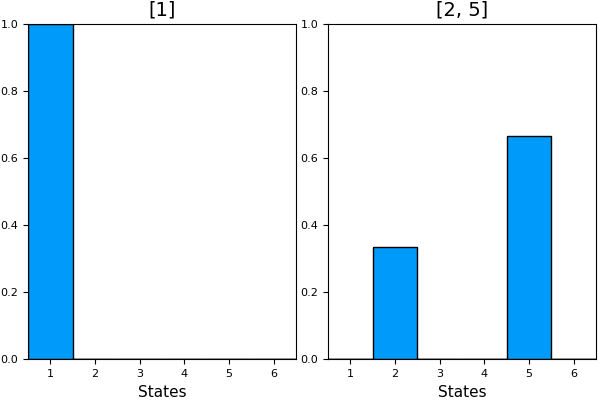

In [17]:
titles = ["$recurrent_class"
          for recurrent_class in recurrent_classes(mc1)]

ps = []
for (title, dist) in zip(titles, stationary_distributions(mc1))
    push!(ps, draw_histogram(dist, title=title, xlabel="States"))
end

plot(ps..., layout=(1, 2))

### Simulation

Let us simulate our Markov chain `mc1`.
The `simualte` method generates a sample path
of length given by the first argument, `ts_length`,
with an initial state as specified by an optional argument `init`;
if not specified, the initial state is randomly drawn. 

A sample path from state `1`:

In [18]:
simulate(mc1, 50, init=1)'

1×50 RowVector{Int64,Array{Int64,1}}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1

As is clear from the transition matrix `P`,
if it starts at state `1`, the chain stays there forever,
i.e., `1` is an absorbing state, a state that constitutes a singleton recurrent class.

Start with state `2`:

In [19]:
simulate(mc1, 50, init=2)'

1×50 RowVector{Int64,Array{Int64,1}}:
 2  5  2  5  2  5  2  5  5  5  5  5  5  …  5  5  5  2  5  5  5  5  2  5  2  5

You can observe that the chain stays in the recurrent class $\{2,5\}$
and visits states `2` and `5` with certain frequencies.

If `init` is not specified, the initial state is randomly chosen:

In [20]:
simulate(mc1, 50)'

1×50 RowVector{Int64,Array{Int64,1}}:
 5  5  5  2  5  5  5  2  5  5  5  2  5  …  2  5  2  5  2  5  2  5  2  5  5  5

**Note on reproducibility**:
You can set a random seed to initialize
the pseudo-random number generator.
As you set the same random seed value,
`simulate` returns the same outcome.

In [21]:
srand(12345) 
simulate(mc1, 50)'

1×50 RowVector{Int64,Array{Int64,1}}:
 3  5  2  5  2  5  5  2  5  2  5  5  5  …  2  5  5  5  5  5  5  2  5  5  2  5

#### Time series averages

Now, let us compute the frequency distribution along a sample path, given by
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\}
\quad (s \in S).
$$

In [22]:
function time_series_dist(mc, t; init=rand(1:n_states(mc)))
    """
    Return the distribution of visits by a sample path of length t
    of mc with an initial state init.
    """
    if typeof(t) == Int #t is an int
        t_max = t
        ts_size = 1
        ts_array = [t]
        dim = 1
    else
        t_max = maximum(t)
        ts_size = length(t)  # t is an array
        ts_array = t
        dim = 2
    end
        
    X = simulate(mc, t_max, init=init)
    dists = [zeros(n_states(mc)) for i in 1:ts_size]
    bins = 1:n_states(mc)+1
    for (i, length) in enumerate(ts_array)
        h = fit(Histogram, X[1:length], bins, closed=:left)
        dists[i] = h.weights / length
    end
    
    if dim == 1
        return dists[1]
    else
        return dists
    end
end

time_series_dist (generic function with 1 method)

Here is a frequency distribution along a sample path,  of length 100,
from initial state `2`, which is a recurrent state:

In [23]:
time_series_dist(mc1, 100, init=2)

6-element Array{Float64,1}:
 0.0
 0.3
 0.0
 0.0
 0.7
 0.0

Length 10,000:

In [24]:
time_series_dist(mc1, 10^4, init=2)

6-element Array{Float64,1}:
 0.0   
 0.3328
 0.0   
 0.0   
 0.6672
 0.0   

The distribution becomes close to the stationary distribution `(0, 1/3, 0, 0, 2/3, 0)`.

Plot the frequency distributions for a couple of different time lengths:

In [25]:
function plot_time_series_dists(mc, ts; init=rand(1:n_states(mc)), layout=(1,length(ts)))
    dists = time_series_dist(mc, ts, init=init)
    titles = ["t=$t" for t in ts]

    ps = []
    for (title, dist) in zip(titles, dists)
        p = draw_histogram(dist, title=title, xlabel="States")
        push!(ps, p)
    end
    plot(ps..., layout=layout)
end

plot_time_series_dists (generic function with 1 method)


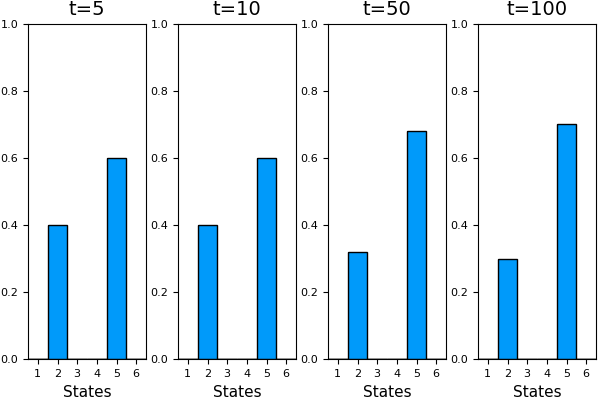

In [26]:
init = 2
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, ts, init=init)

Start with state `3`,
which is a transient state:


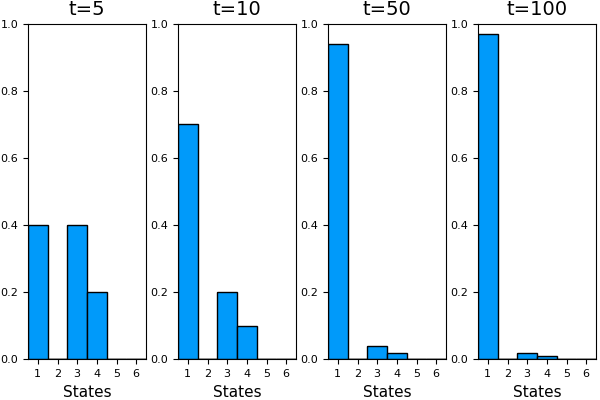

In [27]:
init = 3
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, ts, init=init)

Run the above cell several times;
you will observe that the limit distribution differs across sample paths.
Sometimes the state is absorbed into the recurrent class $\{1\}$,
while other times it is absorbed into the recurrent class $\{2,5\}$.

Some sample path with init=3



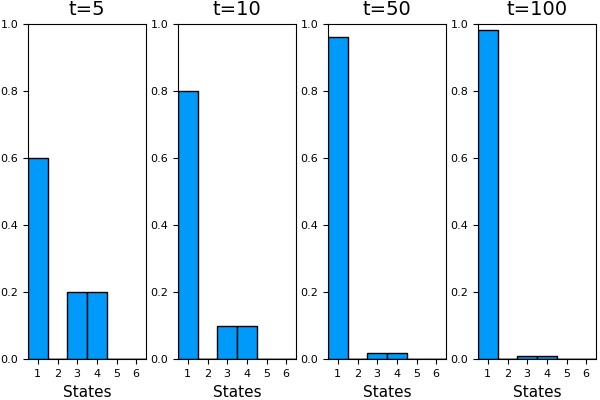

In [28]:
init = 3
ts = [5, 10, 50, 100]
seed = 222
println("Some sample path with init=$init")

srand(seed)
plot_time_series_dists(mc1, ts, init=init)

Another sample path with init=3



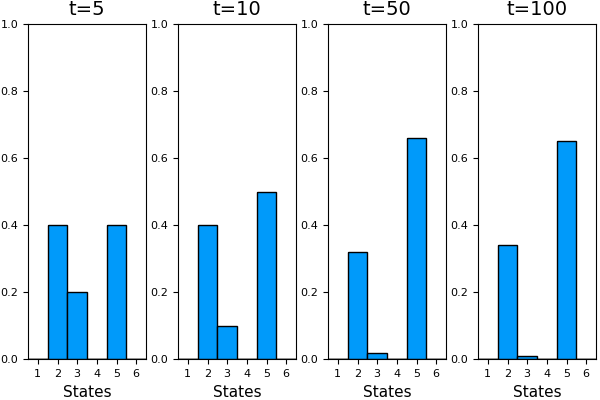

In [29]:
seed = 2222
println("Another sample path with init=$init")

srand(seed)
plot_time_series_dists(mc1, ts, init=init)

In fact,
for almost every sample path of a finite Markov chain $\{X_t\}$,
for some recurrent class $C$ we have
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\} \to \psi^C[s]
\quad \text{as $t \to \infty$}
$$
for all states $s$,
where $\psi^C$ is the stationary distribution associated with the recurrent class $C$.

If the initial state $s_0$ is a recurrent state,
then the recurrent class $C$ above is the one that contains $s_0$,
while if it is a transient state,
then the recurrent class to which the convergence occurs depends on the sample path.

Let us simulate with the remaining states, `4`, `5`, and `6`.

Time series distributions for t=100


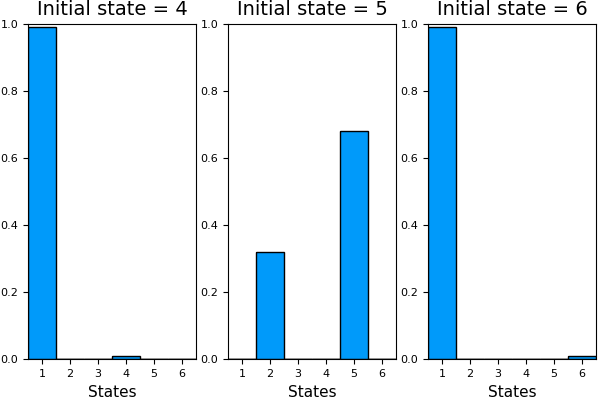

In [30]:
inits = [4, 5, 6]
t = 100

ps = []
for init in inits
    p = draw_histogram(
        time_series_dist(mc1, t, init=init),
        title="Initial state = $init",
        xlabel="States")
    push!(ps, p)
end

plot(ps..., layout=(1, 3))

#### Cross sectional averages

Next, let us repeat the simulation for many times (say, 10,000 times)
and obtain the distribution of visits to each state at a given time period `T`.
That is, we want to simulate the marginal distribution at time `T`.

In [31]:
function QuantEcon.simulate(mc, ts_length, num_reps::Int=10^4; init=1)
    X = Array{Int}(ts_length, num_reps)
    for i in 1:num_reps
        X[:, i] = simulate(mc, ts_length, init=init)
    end
    return X
end

In [32]:
function cross_sectional_dist(mc, T, num_reps=10^4; init=init)
    """
    Return the distribution of visits at time T by num_reps times of simulation
    of mc with an initial state init.
    """
    if typeof(T) == Int  # T is an int
        T_max = T
        Ts_size = 1
        Ts_array = [T]
        dim = 1
    else
        T_max = maximum(T)
        Ts_size = length(T)  # T is an array
        Ts_array = T
        dim = 2
    end

    x = simulate(mc, T_max+1, num_reps, init=init)[Ts_array, :]
    dists = [zeros(n_states(mc)) for i in 1:Ts_size]
    bins = 1:n_states(mc)+1
    for i in 1:Ts_size
        h = fit(Histogram, x[i, :], bins, closed=:left)
        dists[i] = h.weights / num_reps
    end
    
    if dim == 1
        return dists[1]
    else
        return dists
    end
end

cross_sectional_dist (generic function with 2 methods)

Start with state `2`:

In [33]:
init = 2
T = 10
cross_sectional_dist(mc1, T, init=init)

6-element Array{Float64,1}:
 0.0   
 0.3257
 0.0   
 0.0   
 0.6743
 0.0   

In [34]:
T = 100
cross_sectional_dist(mc1, T, init=init)

6-element Array{Float64,1}:
 0.0   
 0.3417
 0.0   
 0.0   
 0.6583
 0.0   

The distribution is close to the stationary distribution (0, 1/3, 0, 0, 2/3, 0).

Plot the simulated marginal distribution at `T` for some values of `T`.

In [35]:
function plot_cross_sectional_dists(mc, Ts, num_reps=10^4; init=1)
    dists = cross_sectional_dist(mc, Ts, num_reps, init=init)
    titles = map(T -> "T=$T", Ts)

    ps = []
    for (title, dist) in zip(titles, dists)
        p = draw_histogram(dist, title=title, xlabel="States")
        push!(ps, p)
    end

    plot(ps..., layout=(1, length(Ts)))
end

plot_cross_sectional_dists (generic function with 2 methods)


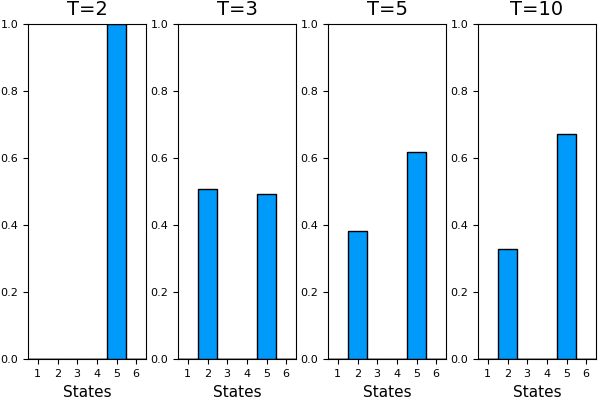

In [36]:
init = 2
Ts = [2, 3, 5, 10]
plot_cross_sectional_dists(mc1, Ts, init=init)

Starting with a transient state `3`:

In [37]:
init = 3
T = 10
cross_sectional_dist(mc1, T, init=init)

6-element Array{Float64,1}:
 0.4942
 0.1692
 0.0   
 0.0024
 0.3324
 0.0018

In [38]:
T = 100
dist = cross_sectional_dist(mc1, T, init=init)

6-element Array{Float64,1}:
 0.4959
 0.1673
 0.0   
 0.0   
 0.3368
 0.0   


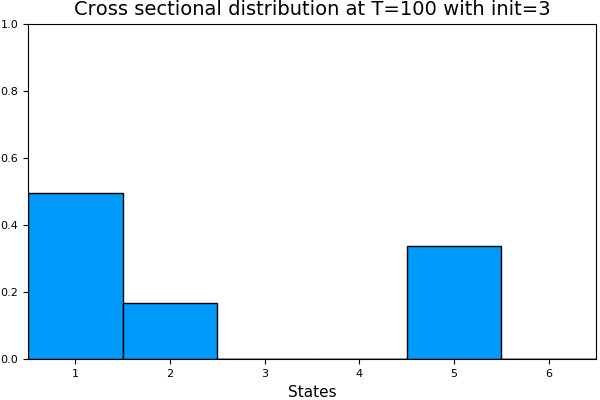

In [39]:
draw_histogram(dist,
               title="Cross sectional distribution at T=$T with init=$init",
               xlabel="States")

Observe that the distribution is close to a convex combination of
the stationary distributions `(1, 0, 0, 0, 0, 0)` and `(0, 1/3, 0, 0, 2/3, 0)`,
which is a stationary distribution itself.

How the simulated marginal distribution evolves:


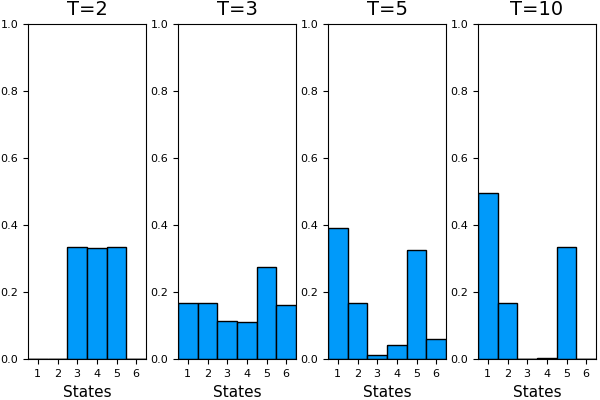

In [40]:
init = 3
Ts = [2, 3, 5, 10]
plot_cross_sectional_dists(mc1, Ts, init=init)

Since our Markov chain is aperiodic (i.e., every recurrent class is aperiodic),
the marginal disribution at time $T$ converges as $T \to \infty$
to some stationary distribution,
and the limit distribution depends on the initial state,
according to the probabilities that the state is absorbed into the recurrent classes.

For initial states `4`, `5`, and `6`:


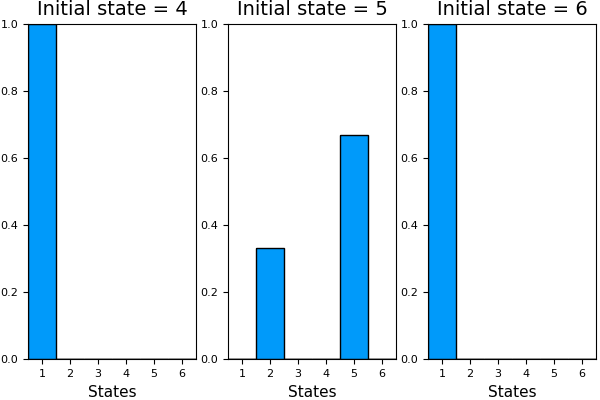

In [41]:
inits = [4, 5, 6]
T = 10

ps = []
for init in inits
    p = draw_histogram(cross_sectional_dist(mc1, T, init=init),
                   title="Initial state = $init",
                   xlabel="States")
    push!(ps, p)
end

plot(ps..., layout=(1, length(inits)))

### Powers of $P$

The marginal distributions at time $T$ are obtained by $P^T$.

In [42]:
Ts = [10, 20, 30]
for T in Ts
    P_T = mc1.p^T
    println("P^$T =\n$P_T")
end

P^10 =
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.333984 0.0 0.0 0.666016 0.0; 0.498072 0.166792 1.69351e-5 0.000767702 0.3332 0.00115155; 0.999023 0.0 0.0 0.000976563 0.0 0.0; 0.0 0.333008 0.0 0.0 0.666992 0.0; 0.999023 0.0 0.0 0.0 0.0 0.000976563]


In the canonical form:

In [43]:
Q = mc1.p[permutation, :][:, permutation]
println("Q =\n$Q")
for T in Ts
    Q_T = Q^T
    println("Q^$T =\n$Q_T")
end

Q =
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0; 0.0 0.5 0.5 0.0 0.0 0.0; 0.0 0.0 0.333333 0.333333 0.333333 0.0; 0.5 0.0 0.0 0.0 0.0 0.5; 0.5 0.0 0.0 0.0 0.5 0.0]
Q^10 =
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.333984 0.666016 0.0 0.0 0.0; 0.0 0.333008 0.666992 0.0 0.0 0.0; 0.498072 0.166792 0.3332 1.69351e-5 0.000767702 0.00115155; 0.999023 0.0 0.0 0.0 0.000976563 0.0; 0.999023 0.0 0.0 0.0 0.0 0.000976563]
Q^20 =
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.333334 0.666666 0.0 0.0 0.0; 0.0 0.333333 0.666667 0.0 0.0 0.0; 0.499998 0.166667 0.333333 2.86797e-10 7.6271e-7 1.14407e-6; 0.999999 0.0 0.0 0.0 9.53674e-7 0.0; 0.999999 0.0 0.0 0.0 0.0 9.53674e-7]
Q^30 =
[1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.333333 0.666667 0.0 0.0 0.0; 0.0 0.333333 0.666667 0.0 0.0 0.0; 0.5 0.166667 0.333333 4.85694e-15 7.45054e-10 1.11758e-9; 1.0 0.0 0.0 0.0 9.31323e-10 0.0; 1.0 0.0 0.0 0.0 0.0 9.31323e-10]


Observe that the first three rows, which correspond to the recurrent states,
are close to the stationary distributions associated with the corresponding recurrent classes.

## Example 2: Periodic chain

Consider the Markov chain given by the following stochastic matrix,
taken from Exercise 9 (see also Exercise 11) in Jarvis and Shier
(where the actual values of non-zero probabilities are not important):

In [44]:
P = zeros(10, 10)
P[1, 4] = 1
P[2, [1, 5]] = 1/2
P[3, 7] = 1
P[4, [2, 3, 8]] = 1/3
P[5, 4] = 1
P[6, 5] = 1
P[7, 4] = 1
P[8, [7, 9]] = 1/2
P[9, 10] = 1
P[10, 6] = 1
P

10×10 Array{Float64,2}:
 0.0  0.0       0.0       1.0  0.0  0.0  0.0  0.0       0.0  0.0
 0.5  0.0       0.0       0.0  0.5  0.0  0.0  0.0       0.0  0.0
 0.0  0.0       0.0       0.0  0.0  0.0  1.0  0.0       0.0  0.0
 0.0  0.333333  0.333333  0.0  0.0  0.0  0.0  0.333333  0.0  0.0
 0.0  0.0       0.0       1.0  0.0  0.0  0.0  0.0       0.0  0.0
 0.0  0.0       0.0       0.0  1.0  0.0  0.0  0.0       0.0  0.0
 0.0  0.0       0.0       1.0  0.0  0.0  0.0  0.0       0.0  0.0
 0.0  0.0       0.0       0.0  0.0  0.0  0.5  0.0       0.5  0.0
 0.0  0.0       0.0       0.0  0.0  0.0  0.0  0.0       0.0  1.0
 0.0  0.0       0.0       0.0  0.0  1.0  0.0  0.0       0.0  0.0

In [45]:
mc2 = MarkovChain(P)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.0 0.0 … 0.0 0.0; 0.5 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0]

This Markov chain is irreducible:

In [46]:
is_irreducible(mc2)

true

This Markov chain is periodic:

In [47]:
is_aperiodic(mc2)

false

Its period, which we denote by $d$:

In [48]:
d = period(mc2)

3

Cyclic classes are:

In [49]:
cyclic_classes = [[1, 5, 7, 9], [4, 10], [2, 3, 6, 8]]

3-element Array{Array{Int64,1},1}:
 [1, 5, 7, 9]
 [4, 10]     
 [2, 3, 6, 8]

### Cyclic normal form

If a Markov chain is periodic with period $d \geq 2$,
then its transition probability matrix is written in the form ("cyclic normal form")
$$
\begin{pmatrix}
0       & P_1    & 0      & 0      & \cdots & 0 \\
0       & 0      & P_2    & 0      & \cdots & 0 \\
0       & 0      & 0      & P_3    & \cdots & 0 \\
\vdots  & \vdots & \vdots & \vdots & \ddots & \vdots \\
0       & 0      & 0      & 0      & \cdots & P_{d-1} \\
P_d & 0      & 0      & 0      & \cdots & 0
\end{pmatrix}.
$$

Represent our Markov chain in cyclic normal form:

In [50]:
permutation = vcat(cyclic_classes...)
Q = mc2.p[permutation, :][:, permutation]

10×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  0.0     
 0.0  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  0.0     
 0.0  0.0  0.0  0.0  1.0  0.0  0.0       0.0       0.0  0.0     
 0.0  0.0  0.0  0.0  0.0  1.0  0.0       0.0       0.0  0.0     
 0.0  0.0  0.0  0.0  0.0  0.0  0.333333  0.333333  0.0  0.333333
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0       1.0  0.0     
 0.5  0.5  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0     
 0.0  0.0  1.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0     
 0.0  1.0  0.0  0.0  0.0  0.0  0.0       0.0       0.0  0.0     
 0.0  0.0  0.5  0.5  0.0  0.0  0.0       0.0       0.0  0.0     

Re-define the Markov chain with the above matrix `Q`:

In [51]:
mc2 = MarkovChain(Q)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Obtain the block components $P_1, \cdots, P_{d}$:

In [52]:
cyclic_classes = [[1, 2, 3, 4], [5, 6], [7, 8, 9, 10]]

3-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4] 
 [5, 6]       
 [7, 8, 9, 10]

In [53]:
P_blocks = []

for i in 1:d
    push!(P_blocks, mc2.p[cyclic_classes[(i-1)%d+1], :][:, cyclic_classes[i%d+1]])
    println("P_$i =")
    println(P_blocks[i])
end

P_1 =
[1

$P^d$ is block diagonal:

In [54]:
P_power_d = mc2.p^d

10×10 Array{Float64,2}:
 0.166667  0.166667  0.5  0.166667  …  0.0       0.0       0.0  0.0     
 0.166667  0.166667  0.5  0.166667     0.0       0.0       0.0  0.0     
 0.166667  0.166667  0.5  0.166667     0.0       0.0       0.0  0.0     
 0.0       1.0       0.0  0.0          0.0       0.0       0.0  0.0     
 0.0       0.0       0.0  0.0          0.0       0.0       0.0  0.0     
 0.0       0.0       0.0  0.0       …  0.0       0.0       0.0  0.0     
 0.0       0.0       0.0  0.0          0.333333  0.333333  0.0  0.333333
 0.0       0.0       0.0  0.0          0.333333  0.333333  0.0  0.333333
 0.0       0.0       0.0  0.0          0.333333  0.333333  0.0  0.333333
 0.0       0.0       0.0  0.0          0.166667  0.166667  0.5  0.166667

In [55]:
P_power_d_blocks = []
ordinals = ["1st", "2nd", "3rd"]

for (i, ordinal) in enumerate(ordinals)
    push!(P_power_d_blocks, P_power_d[cyclic_classes[i], :][:, cyclic_classes[i]])
    println("$ordinal diagonal block of P^d =")
    println(P_power_d_blocks[i])
end

1st diagonal block of P^d =
[0.166667 0.166667 0.5 0.166667; 0.166667 0.166667 0.5 0.166667; 0.166667 0.166667 0.5 0.166667; 0.0 1.0 0.0 0.0]
2nd diagonal block of P^d =
[0.833333 0.166667; 1.0 0.0]
3rd diagonal block of P^d =
[0.333333 0.333333 0.0 0.333333; 0.333333 0.333333 0.0 0.333333; 0.333333 0.333333 0.0 0.333333; 0.166667 0.166667 0.5 0.166667]


The $i$th diagonal block of $P^d$ equals $P_i P_{i+1} \cdots P_d P_1 \cdots P_{i-1}$:

In [56]:
products = []

for i in 1:d
    R = P_blocks[i]
    string = "P_$i"
    for j in 1:d-1
        R = R * P_blocks[(i+j-1)%d+1]
        string *= "P_$((i+j-1)%d+1)"
    end
    push!(products, R)
    println(string)
    println("=$R")
end

P_1P_2P_3
=[0.166667 0.166667 0.5 0.166667; 0.166667 0.166667 0.5 0.166667; 0.166667 0.166667 0.5 0.166667; 0.0 1.0 0.0 0.0]
P_2P_3P_1
=[0.833333 0.166667; 1.0 0.0]
P_3P_1P_2
=[0.333333 0.333333 0.0 0.333333; 0.333333 0.333333 0.0 0.333333; 0.333333 0.333333 0.0 0.333333; 0.166667 0.166667 0.5 0.166667]


In [57]:
for (matrix0, matrix1) in zip(P_power_d_blocks, products)
    println(matrix0 == matrix1)
end

true
true
true


### Stationary distributions

The Markov chain `mc2` has a unique stationary distribution,
which we denote by $\pi$:

In [58]:
length(stationary_distributions(mc2))

1

In [59]:
pi = stationary_distributions(mc2)[1]

10-element Array{Float64,1}:
 0.047619 
 0.0952381
 0.142857 
 0.047619 
 0.285714 
 0.047619 
 0.0952381
 0.0952381
 0.047619 
 0.0952381


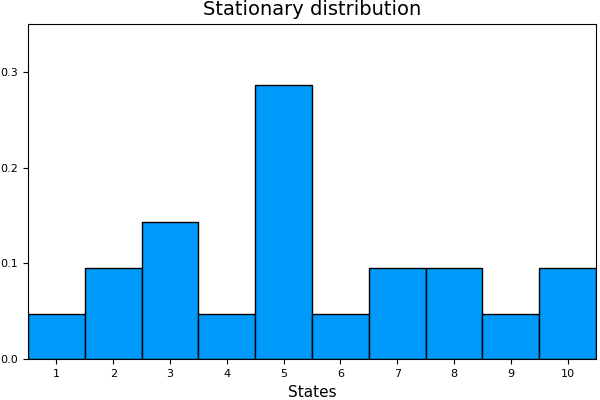

In [60]:
draw_histogram(pi,
               title="Stationary distribution", xlabel="States", ylim=(0, 0.35))

Obtain the stationary distributions $\pi^0, \ldots, \pi^{d-1}$
each associated with the diagonal blocks of $P^d$:

In [61]:
pi_s = []

for i in 1:d
    push!(pi_s, stationary_distributions(MarkovChain(P_power_d_blocks[i]))[1])
    println("pi^$(i-1) =")
    println(pi_s[i])
end

pi^0 =



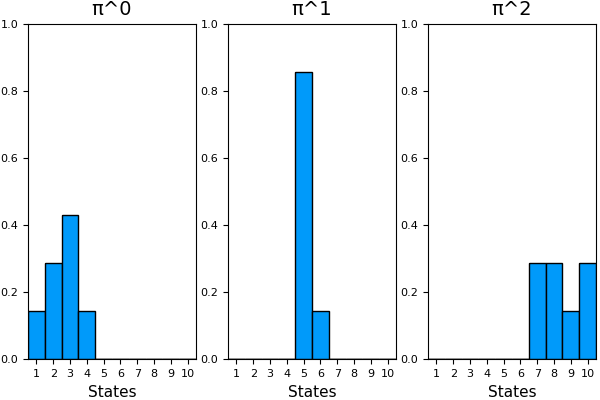

In [62]:
ps = []

for i in 1:d
    pi_i_full_dim = zeros(n_states(mc2))
    pi_i_full_dim[cyclic_classes[i]] = pi_s[i]
    p = draw_histogram(pi_i_full_dim,
                   title="π^$(i-1)", xlabel="States")
    push!(ps, p)
end

plot(ps..., layout=(1, 3))

Verify that $\pi^{i+1} = \pi^i P_i$:

In [63]:
for i in 1:d
    println("pi^$(i-1) P_$(i-1) =")
    println(pi_s[i]' * P_blocks[i])
end

pi^0 P_0 =
[0.857143 0.142857]
pi^1 P_1 =
[0.285714 0.285714 0.142857 0.285714]
pi^2 P_2 =
[0.142857 0.285714 0.428571 0.142857]


Verify that $\pi = (\pi^0 + \cdots + \pi^{d-1})/d$:

In [64]:
# Right hand side of the above identity
rhs = zeros(n_states(mc2))

for i in 1:d
    rhs[cyclic_classes[i]] = pi_s[i]
end
rhs /= d
rhs

10-element Array{Float64,1}:
 0.047619 
 0.0952381
 0.142857 
 0.047619 
 0.285714 
 0.047619 
 0.0952381
 0.0952381
 0.047619 
 0.0952381

In [65]:
maximum(abs.(pi - rhs))

2.7755575615628914e-17

meaning right hand side is very close to $\pi$

### Powers of $P$

Since the Markov chain in consideration is periodic,
the marginal distribution does not converge, but changes periodically.

Let us compute the powers of the transition probability matrix (in cyclic normal form):

Print $P^1, P^2, \ldots, P^d$:

In [66]:
for i in 1:d+1
    println("P^$i =")
    println(mc2.p^i)
end

P^1 =
[0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.333333 0.333333 0.0 0.333333; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0]
P^2 =
[0.0 0.0 0.0 0.0 0.0 0.0 0.333333 0.333333 0.0 0.333333; 0.0 0.0 0.0 0.0 0.0 0.0 0.333333 0.333333 0.0 0.333333; 0.0 0.0 0.0 0.0 0.0 0.0 0.333333 0.333333 0.0 0.333333; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0; 0.166667 0.166667 0.5 0.166667 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.5 0.5 0.0 0.0 0.0 0.0]
P^3 =
[0.166667 0.166667 0.5 0.166667 0.0 0.0 0.0 0.0 0.0 0.0; 0.166667 0.166667 0.5 0.1666

Print $P^{2d}$, $P^{4d}$, and $P^{6d}$:

In [67]:
for i in [k*d for k in [2, 4, 6]]
    println("P^$i =")
    println(mc2.p^i)
end

P^6 =


$P^{kd}$ converges as $k \to \infty$ to a matrix that contains $\pi^0, \ldots, \pi^{d-1}$.

Print $P^{kd+1}, \ldots, P^{kd+d}$ with $k = 10$ for example:

In [68]:
for i in 10*d+1:11*d
    println("P^$i =")
    println(mc2.p^i)
end

P^31 =
[0.0 0.0 0.0 0.0 0.857143 0.142857 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.857143 0.142857 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.857143 0.142857 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.857143 0.142857 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0]
P^32 =
[0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.0 0.0 0.0 0.0 0.0 0.0 0.285714 0.285714 0.142857 0.285714; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0; 0.142857 0.285714 0.428571 0.142857 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.857143 0.142857 0.0 0.0 0.0 0.

But $P^i$ itself does not converge.

## Simulation

Plot the frequency distribution of visits to the states
along a sample path starting at state `1`:

In [69]:
init = 1
dist = time_series_dist(mc2, 10^4, init=init)

10-element Array{Float64,1}:
 0.0486
 0.0953
 0.1431
 0.0464
 0.2869
 0.0464
 0.0974
 0.0985
 0.0464
 0.091 


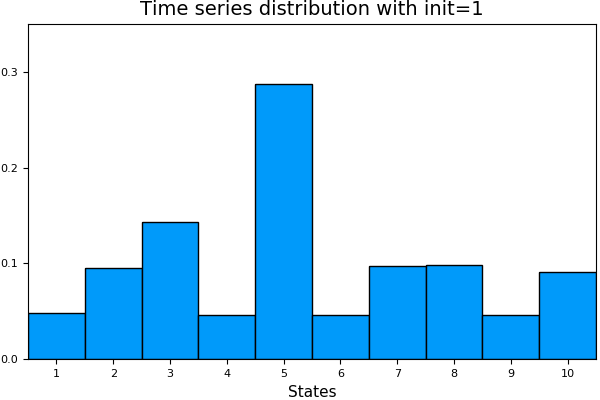

In [70]:
draw_histogram(dist,
               title="Time series distribution with init=$init",
               xlabel="States", ylim=(0, 0.35))

Observe that the distribution is close to the (unique) stationary distribution $\pi$.

In [71]:
pi

10-element Array{Float64,1}:
 0.047619 
 0.0952381
 0.142857 
 0.047619 
 0.285714 
 0.047619 
 0.0952381
 0.0952381
 0.047619 
 0.0952381


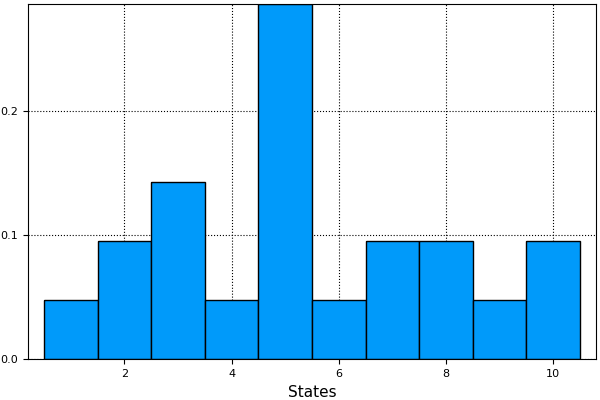

In [72]:
bar(pi, legend=false, xlabel="States")

Next, plot the simulated marginal distributions
at $T = 10d+1, \ldots, 11d, 11d+1, \ldots, 12d$ with initial state `1`:


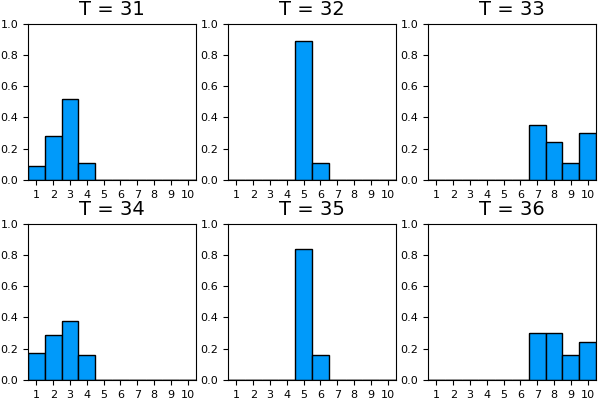

In [73]:
init = 1
k = 10
Ts = [k*d + i for i in 1:2*d]
num_reps = 10^2
dists = cross_sectional_dist(mc2, Ts, num_reps, init=init)

ps = []
for (dist, T) in zip(dists, Ts)
    p = draw_histogram(dist,
                   title="T = $T")
    push!(ps, p)
end
plot(ps..., layout=(2, d))

Compare these with the rows of $P^{10d+1}, \ldots, P^{10d+d}$.

## Example 3: Nearly completely decomposable chain

Consider the Markov chain given by the following stochastic matrix $P^{\varepsilon}$,
parameterized by $\varepsilon$:

In [74]:
function P_epsilon(eps, p=0.5)
    P = [1-(p+eps) p         eps;
        p         1-(p+eps) eps;
        eps       eps       1-2*eps]
    return P
end

P_epsilon (generic function with 2 methods)

If $\varepsilon = 0$,
then the Markovh chain is reducible into two recurrent classes, `[1, 2]` and `[3]`:

In [75]:
P_epsilon(0)

3×3 Array{Float64,2}:
 0.5  0.5  0.0
 0.5  0.5  0.0
 0.0  0.0  1.0

In [76]:
recurrent_classes(MarkovChain(P_epsilon(0)))

2-element Array{Array{Int64,1},1}:
 [1, 2]
 [3]   

If $\varepsilon > 0$ but small, the chain is irreducible,
but transition within each of the subsets `[1, 2]` and `[3]` is much more likely
than that between these sets.

In [77]:
P_epsilon(0.001)

3×3 Array{Float64,2}:
 0.499  0.5    0.001
 0.5    0.499  0.001
 0.001  0.001  0.998

In [78]:
recurrent_classes(MarkovChain(P_epsilon(0.001)))

1-element Array{Array{Int64,1},1}:
 [1, 2, 3]

Analytically, the unique stationary distribution of the chain with $\varepsilon > 0$
is `(1/3, 1/3, 1/3)`, independent of the value of $\varepsilon$.

`MarkovChain` in `quantecon` employs
the algorithm called the "[GTH algorithm](http://quanteconpy.readthedocs.org/en/stable/markov/gth_solve.html)",
which is a numerically stable variant of Gaussian elimination,
specialized for Markov chains.

In [79]:
epsilons = [10.0^(-i) for i in 12:17]
push!(epsilons, 1e-100)
for eps in epsilons
    println("epsilon = $eps")
    println(stationary_distributions(MarkovChain(P_epsilon(eps)))[1])
end

epsilon = 1.0e-12
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-13
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-14
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-15
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-16
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-17
[0.333333, 0.333333, 0.333333]
epsilon = 1.0e-100
[0.333333, 0.333333, 0.333333]


It succeeds in obtaining the correct stationary distribution for any value of $\varepsilon$.